In [9]:
import pandas
import glob
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

# Sequences with very few plasmids give unreliable outputs.
# A cutoff of 20 DNA counts is recommended by Ernst et. al.
DNA_COUNT_THRESH = 20

cells = ["HepG2", "K562"]
design = 'PilotDesign'
promoter = 'SV40P'

In [2]:
def quantile_plot(x, y, quantiles = 5000, ax = None, s = 5):
    assert x.shape == y.shape
    data_pairs = [(X, Y) for X, Y in zip(x, y)]
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    if ax:
        ax.scatter(avg_activity, avg_score, c = 'r', s=s)
    else:
        plt.scatter(avg_activity, avg_score, c = 'r', s=s)
        plt.show()

In [54]:
def read_counts(fn):
    data = pandas.read_csv(fn, sep= '\t', header = 0)
    names  = data[["ID"]].as_matrix().reshape(-1)
    seq    = data[["Sequence"]].as_matrix().reshape(-1)
    counts = map(lambda x: x.split(','),
                 data[["Counts"]].as_matrix().reshape(-1))
    return names, seq, np.vstack(counts).astype('int')

In [55]:
def get_counts(cell, promoter, design, names=None, seqs=None):
    # Find relevant files.
    # Note that there is one plasmid library used for each promoter.
    rna1 = glob.glob("raw/*{}_{}_{}_mRNA_Rep1*".format(cell, design, promoter))
    rna2 = glob.glob("raw/*{}_{}_{}_mRNA_Rep2*".format(cell, design, promoter))
    dna1 = glob.glob("raw/*{}_{}_Plasmid_Rep1*".format(design, promoter))
    dna2 = glob.glob("raw/*{}_{}_Plasmid_Rep2*".format(design, promoter))
    assert len(rna1) == len(rna2) == len(dna1) == len(dna2) == 1

    # Read in names, sequences, and counts.
    rna1_names, rna1_seqs, rna1_counts = read_counts(rna1[0])
    rna2_names, rna2_seqs, rna2_counts = read_counts(rna2[0])
    dna1_names, dna1_seqs, dna1_counts  = read_counts(dna1[0])
    dna2_names, dna2_seqs, dna2_counts  = read_counts(dna2[0])

    # ... and assure that they are concordant.
    assert (np.all(rna1_seqs == rna2_seqs)
            and np.all(rna2_seqs == dna1_seqs)
            and np.all(dna1_seqs == dna2_seqs))
    assert (np.all(rna1_names == rna2_names)
            and np.all(rna2_names == dna1_names)
            and np.all(dna1_names == dna2_names))
    assert (rna1_counts.shape == rna2_counts.shape
            == dna1_counts.shape == dna2_counts.shape)

    # ... and they match the previously read names and sequences.
    if names is not None:
        assert np.all(names == dna1_names)
        assert np.all(seqs  == dna1_seqs)
    seqs, names = dna1_seqs, dna1_names
    return (names, seqs, rna1_counts, rna2_counts,
            dna1_counts, dna2_counts)

In [56]:
names = None
seqs = None
rna1 = []
rna2 = []
dna1 = []
dna2 = []
header = ['Name']
for cell in cells:
    header += ["{}".format(cell)]
    (names, seqs,
     r1, r2, d1, d2) = get_counts(cell, promoter, design, names, seqs)
    rna1 += [r1]
    rna2 += [r2]
    dna1 += [d1]
    dna2 += [d2]
rna1 = np.vstack(rna1)
rna2 = np.vstack(rna2)
dna1 = np.vstack(dna1)
dna2 = np.vstack(dna2)
assert rna1.shape == rna2.shape == dna1.shape == dna2.shape

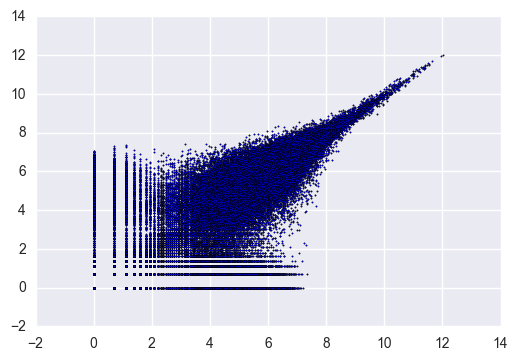

In [68]:
plt.scatter(np.log(rna1+1), np.log(rna2+1), s = 1)
plt.show()

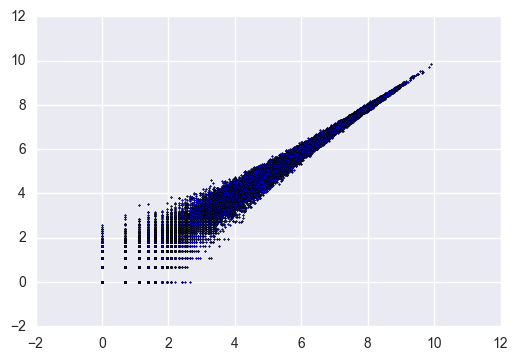

In [73]:
plt.scatter(np.log(dna1 + 1), np.log(dna2 + 1), s = 1)
plt.show()

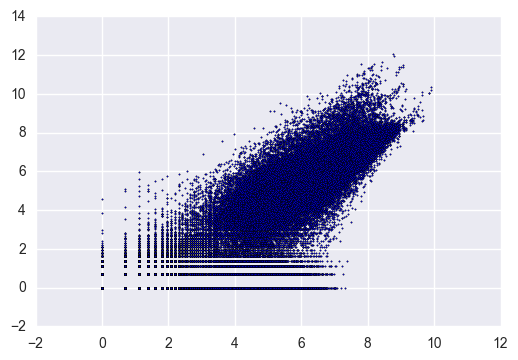

In [72]:
plt.scatter(np.log(dna1+1), np.log(rna1+1), s = 1)
plt.show()

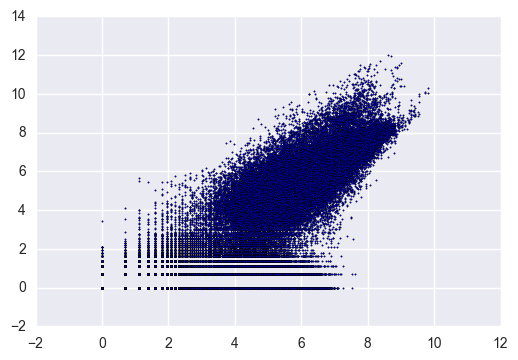

In [74]:
plt.scatter(np.log(dna2+1), np.log(rna2+1), s = 1)
plt.show()

In [98]:
def act(rna, dna, thresh = -1):
    return (np.log(rna + 1) - np.log(dna + 1)
            - np.log(sum(rna + 1)) + np.log(sum(dna + 1)))

In [99]:
act1 = act(rna1[:, :12], dna1[:, :12])
act2 = act(rna2[:, :12], dna2[:, :12])

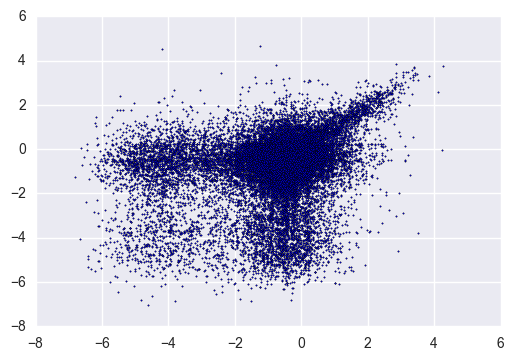

In [101]:
plt.scatter(act1[:, :6], act1[:, 6:], s = 1)
plt.show()

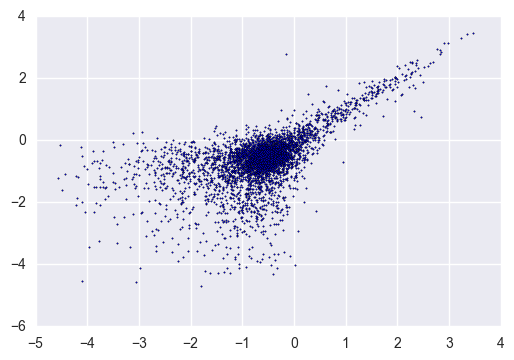

In [116]:
plt.scatter(np.median(act1[:, :6], axis = 1),
            np.median(act1[:, 6:], axis = 1),
            s = 1)
plt.show()

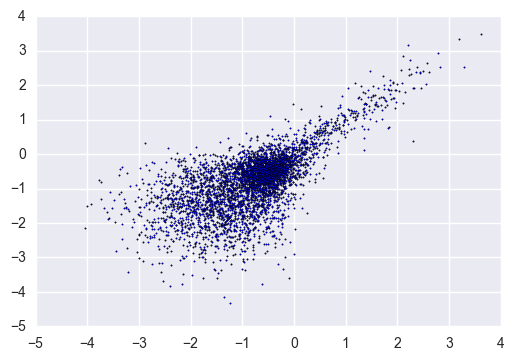

In [118]:
plt.scatter(np.mean(act1[:, :6], axis = 1),
            np.mean(act1[:, 6:], axis = 1),
            s = 1)
plt.show()

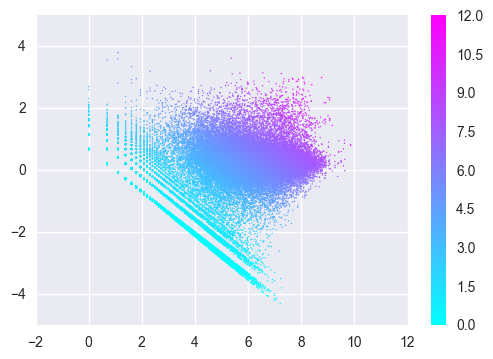

In [117]:
sc = plt.scatter(np.log(dna1[:, :12]+1),
                 stats.zscore(act1),
                 c = np.log(rna1[:, :12]+1),
                 cmap = 'cool',
                 lw = 0, s = 1)
plt.colorbar(sc)
plt.show()

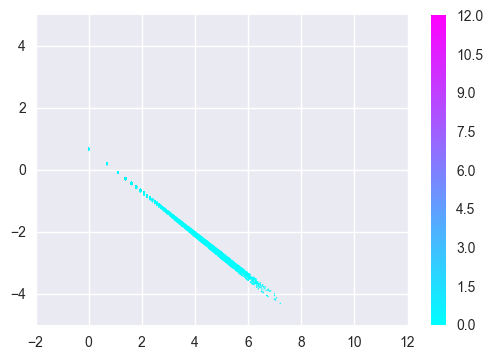

In [135]:
sc = plt.scatter(np.log(dna1[:, :12]+1),
                 stats.zscore(act1),
                 c = np.log(rna1[:, :12]+1),
                 cmap = 'cool',
                 lw = 0,
                 s = rna1[:, :12] == 0)
plt.colorbar(sc)
plt.show()

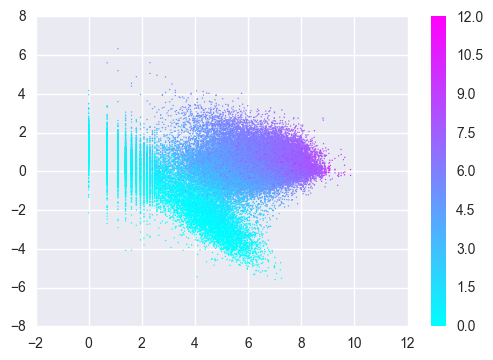

In [152]:
dev = act1 - np.vstack(12 * [act1.mean(axis = 1)]).T
sc = plt.scatter(np.log(dna1[:, :12] + 1), dev,
                 c = np.log(rna1[:, :12]+1),
                 cmap = 'cool',
                 s = 1,
                 lw = 0)
plt.colorbar(sc)
plt.show()

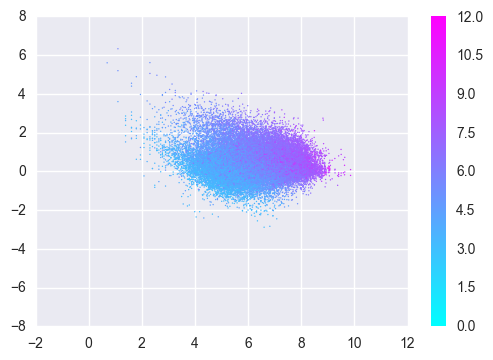

In [151]:
dev = act1 - np.vstack(12 * [act1.mean(axis = 1)]).T
sc = plt.scatter(np.log(dna1[:, :12] + 1), dev,
                 c = np.log(rna1[:, :12]+1),
                 cmap = 'cool',
                 s = np.log(rna1[:, :12]+1) > 3,
                 lw = 0)
plt.colorbar(sc)
plt.show()

# See if we improve the correlation

(27000,) (27000,)
(14483,)


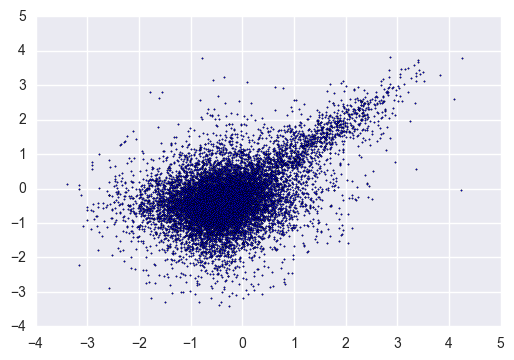

In [165]:
x, y = act1[:, :6].flatten(), act1[:, 6:].flatten()
print x.shape, y.shape
idx = np.logical_and(rna1[:, :6].flatten() > 20,
                     rna1[:, 6:12].flatten() > 20)
x, y = x[idx], y[idx]
print x.shape
plt.scatter(x, y, s = 1)
plt.show()

(27000,) (27000,)
(19970,)


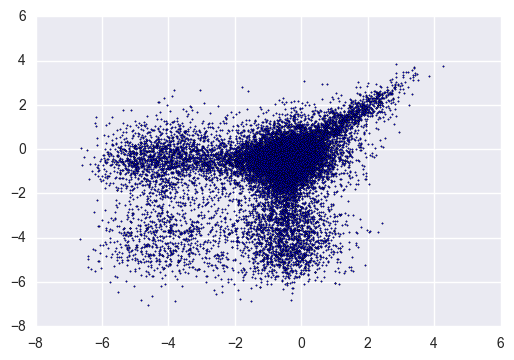

In [164]:
x, y = act1[:, :6].flatten(), act1[:, 6:].flatten()
print x.shape, y.shape
idx = np.logical_and(dna1[:, :6].flatten() > 20,
                     dna1[:, 6:12].flatten() > 20)
x, y = x[idx], y[idx]
print x.shape
plt.scatter(x, y, s = 1)
plt.show()

(27000,) (27000,)
(14350,)


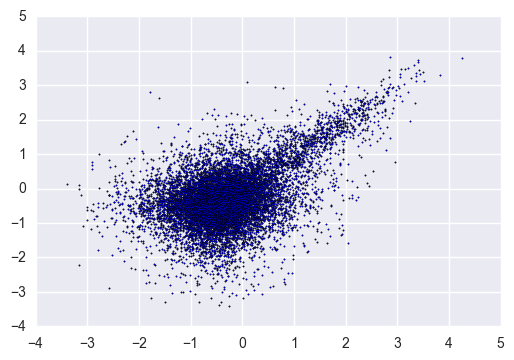

In [163]:
x, y = act1[:, :6].flatten(), act1[:, 6:].flatten()
print x.shape, y.shape
idx = np.logical_and(
                    np.logical_and(dna1[:, :6].flatten() > 20,
                     dna1[:, 6:12].flatten() > 20),
                    np.logical_and(
                     rna1[:, :6].flatten() > 20,
                     rna1[:, 6:12].flatten() > 20))
x, y = x[idx], y[idx]
print x.shape
plt.scatter(x, y, s = 1)
plt.show()